## 01: Showcase basic data loading and manipulation

In [90]:
%load_ext autoreload
%autoreload 2

import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from alphatools.io.anndata_factory import AnnDataFactory
from alphatools.pp import add_metadata

logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Read a dataset:

DIANN returns precursor report tables (.tsv or .parquet format). Usually, we want to load this table, perform some filtering on precursor and protein FDR, and pivot it in order to obtain protein-group intensities. In practice, this aggregates multiple rows of precursor values belonging to one protein group into a single value for that protein group, producing the familiar sample x protein matrix we can work with.

In [91]:
# Copy this file to the folder this notebook runs in. This is a randomized version of a plasma report
# with spiked in outliers to showcase the loading and plotting functions.
report_path = "../data/report_random_scrambled.tsv"

# The factory instance takes care of loading and filtering the data
factory = AnnDataFactory.from_files(
    file_paths=report_path,
    reader_type="diann",
    raw_name_column="Run",
    protein_id_column="Protein.Group",
    intensity_column="PG.MaxLFQ",
)

# Pivot the table in order to get Protein.Group intensities
adata = factory.create_anndata()

/Users/vincenthbrennsteiner/miniconda3/envs/alphaverse/lib/python3.11/site-packages/alphabase/psm_reader/psm_reader.py:259: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename, sep=sep, keep_default_na=False)


### 2. Inspect the AnnData object

AnnData objects work like DataFrames - but better! In using DataFrames, one usually runs into the same issues over and over again:

1. Some columns are numeric, but some are just annotation (metadata), and we permanently have to exclude them for ttests, visualizations, etc. And, if we decide to put them in a separate DataFrame, we constantly have to worry about keeping the 'metadata' dataframe and the 'data' dataframe aligned
2. Indices can be multi-level, but MultiLevel indices generate confusion very easily, and accessing their respective index levels is cumbersome
3. Multiple dataframes that are just same-shaped transformations of each other (for example, raw data, logged data, normalized data, etc.) clutter the workspace and are difficult to manage. 

This and more is solved by AnnData, the standard data format from Scanpy, and now the standard of the Scverse. Simplified for our purposes, an AnnData object has a central data array ('X'), flanked by a DataFrame for row-wise annotation ('obs') and one for column-wise annotation ('var'). These annotation dataframes link to the main array via their respective indices [*], and can be easily accessed. Let's explore the AnnData object we just created: it should contain protein group abundance values, its columns are proteins and its rows are samples. Furthermore it contains sample metadata ('obs') and feature metadata ('var'), which don't interfere with whatever numerical analyses we want to run on the values.

[*] It is possible to add nonmatching metadata to conventional AnnData objects by just assigning 'obs' or 'var' directly. AlphaTools' 'add_metadata' function takes this uncertainty away and ensures that everything stays correctly aligned. 

In [92]:
# Check out the anndata object
print(adata)
print("\n---\n")

# Let's see the protein values
print("Some protein values from the anndata object")
print(
    "Note that this is a numpy array, so there are no column or row indices: \nThis information is stored in the obs and var dataframes, and their alignment to the data matrix.\n"
)
print(adata.X[:5, :5])
print("\n---\n")

# Let's check out the obs and var dataframes
print("Obs dataframe, accessed by adata.obs")
display(adata.obs.head())
print("Not much here yet, but this is what we will use to match metadata to the data matrix.")
print("\n---\n")

# Let's check out the var dataframe
print("Var dataframe, accessed by adata.var")
display(adata.var.head())
print("Same as above, think of this as the column names of the data matrix, which we can use to add more metadata.")

AnnData object with n_obs × n_vars = 111 × 2112

---

Some protein values from the anndata object
Note that this is a numpy array, so there are no column or row indices: 
This information is stored in the obs and var dataframes, and their alignment to the data matrix.

[[4.65202e+03 7.25722e+03 2.44311e+04 1.50955e+04 2.64588e+05]
 [7.58200e+03 4.69074e+03 1.01745e+04 5.48231e+02 2.65509e+05]
 [8.29987e+03 1.91775e+03 6.94765e+03 3.89882e+03 4.61355e+05]
 [4.44628e+03 7.36536e+03 1.43340e+04 4.42771e+03 1.36799e+06]
 [9.46845e+03 8.76362e+03 8.00786e+03 1.46423e+04 1.62578e+05]]

---

Obs dataframe, accessed by adata.obs


""
raw_name
sample_0
sample_1
sample_10
sample_100
sample_101


Not much here yet, but this is what we will use to match metadata to the data matrix.

---

Var dataframe, accessed by adata.var


""
proteins
A0A024QZX5
A0A024R0K5
A0A024R1R8;Q9Y2S6
A0A024R6N5;A0A0G2JRN3
A0A075B6H7


Same as above, think of this as the column names of the data matrix, which we can use to add more metadata.


## Adding metadata to AnnData objects

Easy as 1-2-3

In [93]:
sample_metadata = pd.read_csv("../data/report_random_scrambled_sample_metadata.tsv", sep="\t", index_col=0)

print("Sample metadata, accessed by sample_metadata")
display(sample_metadata.head())
print("This is the metadata we will use to add to the obs dataframe.")
print("\n---\n")

feature_metadata = pd.read_csv("../data/report_random_scrambled_feature_metadata.tsv", sep="\t", index_col=0)

print("Feature metadata, accessed by feature_metadata")
display(feature_metadata.head())
print("This is the metadata we will use to add to the var dataframe.")
print("\n---\n")

Sample metadata, accessed by sample_metadata


,treatment,celltype,batch
Run,,,
sample_0,control,Round,B
sample_1,treatment,Oblique,A
sample_2,control,Oblique,A
sample_3,control,Oblique,B
sample_4,treatment,Diffuse,B


This is the metadata we will use to add to the obs dataframe.

---

Feature metadata, accessed by feature_metadata


,Genes
Protein.Group,
P36578,RPL4
A6NIH7,UNC119B
P05154,SERPINA5
Q9Y490;Q9Y490-2,TLN1
P13497-5,BMP1


This is the metadata we will use to add to the var dataframe.

---



In [94]:
# Let's add the sample metadata to the obs dataframe
adata = add_metadata(adata=adata, incoming_metadata=sample_metadata, axis=0)  # Mind the axis argument: 0 is for rows
print("Obs dataframe after adding sample metadata with add_metadata()")
display(adata.obs.head())
print("Note that matching happened on the index. If the indices had not matched, the rows would be NAN-rows.")
print(
    "This is different from just adding obs columns, which would also work with nonmatching indices as long as the lengths match."
)
print("\n---\n")

# Now let's add the feature metadata
adata = add_metadata(
    adata=adata, incoming_metadata=feature_metadata, axis=1
)  # Mind the axis argument: 1 is for columns
print("Var dataframe after adding feature metadata with add_metadata()")
display(adata.var.head())
print(
    "Note that even though this annotates the protein columns, the 'var' index is still row-based: whether we are dealing with obs or var, \nthe matching is always row-wise."
)

Obs dataframe after adding sample metadata with add_metadata()


,treatment,celltype,batch
raw_name,,,
sample_0,control,Round,B
sample_1,treatment,Oblique,A
sample_10,control,Oblique,A
sample_100,control,Round,B
sample_101,control,Oblique,B


Note that matching happened on the index. If the indices had not matched, the rows would be NAN-rows.
This is different from just adding obs columns, which would also work with nonmatching indices as long as the lengths match.

---

Var dataframe after adding feature metadata with add_metadata()


,Genes
proteins,
A0A024QZX5,SERPINB6
A0A024R0K5,CEACAM5
A0A024R1R8;Q9Y2S6,TMA7;TMA7B
A0A024R6N5;A0A0G2JRN3,SERPINA1
A0A075B6H7,IGKV3-7


Note that even though this annotates the protein columns, the 'var' index is still row-based: whether we are dealing with obs or var, 
the matching is always row-wise.


## Preliminary summary:

This might not seem like much happened, but it takes a huge burden off our shoulders: 

1. Thanks to AnnData, we don't have to worry about aligning dataframe indices or multilevel indices. 
2. Thanks to the AlphaTools 'add_metadata' function, we can be certain that when we add metadata later, everything stays aligned. We could go ahead and add more metadata dataframes with matching indices in.

## Log-transformation

Seemingly trivial, there are nonetheless edgecases: What do we do with zeros? Negative values? -Inf/Inf values? AlphaTools' nanlog() function takes care of this by replacing values without valid logs with nan:

In [95]:
from alphatools.pp.transform import nanlog

adata = nanlog(adata, log=2)

# nanlog also works on DataFrames, Series and numpy arrays

## Filtering for data completeness

Sometimes we only want protein features in the data which have a certain amount of valid values, for example features which have non-na values in at least 30 % of all samples. We can enforce this by using AlphaTools' completeness filter. Feature annotations are filtered accordingly.

In [96]:
from alphatools.pp.data import filter_data_completeness

print(f"Before filtering, adata has the shape {adata.shape}")
adata_2 = filter_data_completeness(adata, max_missing=0.1, axis=0)
print(f"After filtering, adata has the shape {adata_2.shape}")

Before filtering, adata has the shape (111, 2112)
After filtering, adata has the shape (111, 1032)


## More complex data filtering

For some investigations we need to restrict data to certain classes or subsets. Doing so with Pandas filtering can get complicated with multiple conditions, which is why AlphaTools implements a simple, dictionary-based filtering approach.

In [97]:
from alphatools.pp.data import filter_by_metadata

print("Inspect the distribution of obs variables for the data again:")
print()
# Let's check the distribution of treatments, celltypes and batches
print(adata_2.obs[["treatment", "celltype", "batch"]].value_counts())

# Filtering for
# - celltype 'Round' AND
# - treatment 'Control' AND
# - batch 'A'

print("\n---\n")
print("Filtering for celltype 'Round' AND treatment 'Control' AND batch 'A':")

adata_3 = filter_by_metadata(
    adata=adata_2,
    filter_dict={"celltype": "Round", "treatment": "control", "batch": "A"},
    axis=0,
    logic="and",
)
print(f"After filtering, adata has the shape {adata_3.shape}")
print("\n---\n")

print("Filtering for celltype 'Round' OR treatment 'Control' OR batch 'A':")

adata_4 = filter_by_metadata(
    adata=adata_2,
    filter_dict={"celltype": "Round", "treatment": "control", "batch": "A"},
    axis=0,
    logic="or",
)
print(f"After filtering, adata has the shape {adata_4.shape}")
print("\n---\n")

Inspect the distribution of obs variables for the data again:

treatment  celltype   batch
treatment  Diffuse    B        13
control    Elongated  A        11
           Round      B         9
treatment  Oblique    B         9
control    Oblique    A         8
treatment  Elongated  B         7
           Round      B         7
control    Diffuse    A         6
           Oblique    B         6
           Round      A         6
           Diffuse    B         5
           Elongated  B         5
treatment  Diffuse    A         5
           Elongated  A         5
           Round      A         5
           Oblique    A         4
Name: count, dtype: int64

---

Filtering for celltype 'Round' AND treatment 'Control' AND batch 'A':
After filtering, adata has the shape (6, 1032)

---

Filtering for celltype 'Round' OR treatment 'Control' OR batch 'A':
After filtering, adata has the shape (82, 1032)

---



## Summary 2:

We saw that using AlphaTools we can align, preprocess and filter data. As development continues, the initial release will contain more features of that kind, but they all have one thing in common: Rather than black-box, end-to-end solutions, each of these functionalities is standalone and can be integrated in an AnnData based Python pipeline.

## Plotting

Visualization is key to scientific communication, and a good visual style with strong defaults goes a long way. When one does not have to worry about line widths, fontsizes, coloring, layering of different plot elements, a lot of mental load is taken off the user. Most importantly, when the plot looks *exactly* the same in the saved image than it does in the Notebook preview, that tends to save a lot of time going back and forth between code and output.

Inspired by **stylia** [REF], AlphaTools employs intuitive, low-complexity styling solutions for MatplotLib visuals. The underlying Axes object (the data structure which holds data visualizations like points, lines, text, etc.) is always exposed, meaning that the user can build on a solid stylistic foundation while implementing their own unique solutions.

In [98]:
from alphatools.pl import colors
from alphatools.pl.colors import show_rgba_color_list
from alphatools.pl.figure import create_figure, label_axes, save_figure

### Basic colors, palettes and color maps for AlphaTools

Basic colors:

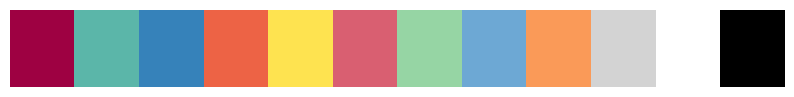

In [99]:
# colors, derived from the basic palette
base_colors = [
    "red",
    "green",
    "blue",
    "orange",
    "yellow",
    "lightred",
    "lightgreen",
    "lightblue",
    "lightorange",
    "grey",
    "white",
    "black",
]
show_rgba_color_list([colors.BaseColors.get(base_color) for base_color in base_colors])

Discrete color palettes:


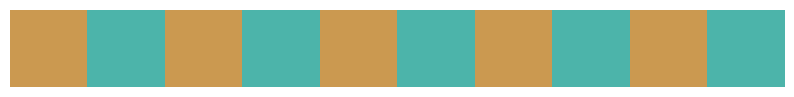

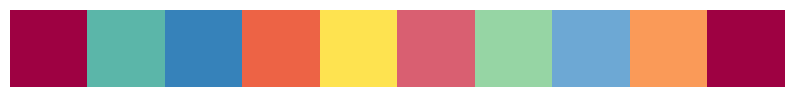

In [100]:
# color palettes
palettes = ["binary", "qualitative"]
for palette in palettes:
    show_rgba_color_list(colors.BasePalettes.get(palette))

Continuous colormaps (diverging for heatmaps)

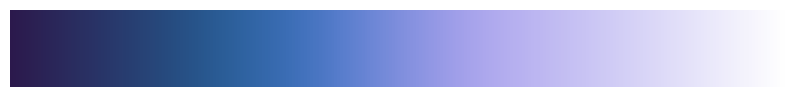

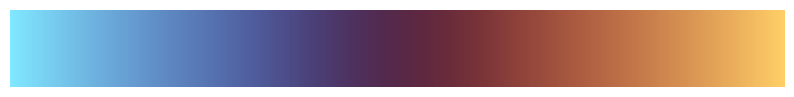

In [101]:
# colormaps
maps = ["sequential", "diverging"]
for cmap in maps:
    show_rgba_color_list(list(colors.BaseColormaps.get(cmap)(np.arange(0, 1, 0.001))))

## Demonstrating the core plotting logic with synthetic data

Here, we generate a set of synthetic data using some underlying mathematical functions. One peculiarity, but great strength of AlphaTools lies in a inconspicuous method: **create_figure**, which wraps Matplotlib's subplots method. We specify the number of rows and columns we want, and the figure size itself upfront. 

What we get is a **matplotlib.pyplot.Figure** instance, and an **alphatools.pl.figure.AxisManager** instance. The latter is an iterator, which means that we can jump from one window to the next by calling AxisManager.next(). While conventional access to subplots is also possible with indices, this iterative approach is very helpful when generating plots in a loop. Under the hood, create_figure also sets a few sensible defaults for the plot fonts and layout.

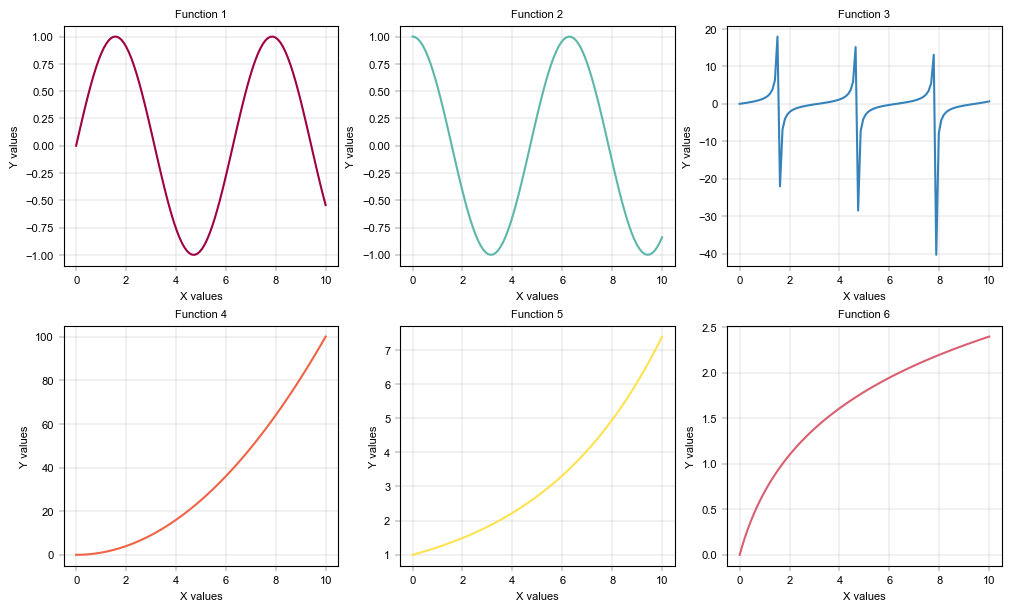

In [102]:
import numpy as np

# Create a 2x3 grid of subplots. Return an instance of AxisManager
fig, axm = create_figure(nrows=2, ncols=3, figsize=(10, 6))

# Example dataset
x = np.linspace(0, 10, 100)
y_funcs = [
    lambda x: np.sin(x),
    lambda x: np.cos(x),
    lambda x: np.tan(x),
    lambda x: x**2,
    lambda x: np.exp(x / 5),
    lambda x: np.log(x + 1),
]

# Get qualitative palette
palette = colors.BasePalettes.get("qualitative", len(y_funcs))

# Iterate through all axes using next() and plot different functions
for i, func in enumerate(y_funcs):
    # Importantly, this is just an ax object, so any matplotlib operation works here
    ax = axm.next()

    # Calling a standard matplotlib function is always possible
    ax.plot(x, func(x), color=palette[i])

    # AlphaTools function to quickly label Axes with proper fontsizes
    label_axes(ax, xlabel="X values", ylabel="Y values", title=f"Function {i + 1}")

plt.show()

# Save the figure
save_figure(
    fig=fig,
    filename="example_figure.png",
    output_dir="./example_outputs",
    dpi=300,
    transparent=False,
)

## Two-sided two-sample t-test to compare groups

Suppose we are interested in a comparison between the treatments 'treatment' and 'control', but only in the 'Oblique' celltype. AlphaTools will eventually integrate AlphaQuant and more sophisticated tests, but for now we work with a simple two-sided, two-sample Student's t-test and Benjamini-Hochberg p-value correction. Missing values, groups with too few samples and generation of corrected p-values are all handled automatically.

In [103]:
from alphatools.tl.stats import ttest

In [115]:
# Filter data as required
adata_for_ttest = filter_by_metadata(
    adata=adata_2,  # The completeness-filtered adata
    filter_dict={
        "celltype": "Oblique",
        "treatment": ["control", "treatment"],
    },
    logic="and",
    axis=0,
)

# Comparisons for the ttest (arbitrary number of comparisons)
ttest_results = ttest(
    adata=adata_for_ttest,
    between="treatment",
    equal_var=True,
)

# Add in gene names
ttest_results = ttest_results.join(adata_for_ttest.var[["Genes"]])

## Plotting our data:

AlphaTools does not yet have a dedicated Volcanoplot Method, so we have to make the plot ourselves - however, this serves to highlight how easy it is to work with AlphaTools: We just take what we need - a figure, a scatterplot, lines, labels, titles and make our own volcanoplot in a few lines of Python code.

(-2.5, 2.5)

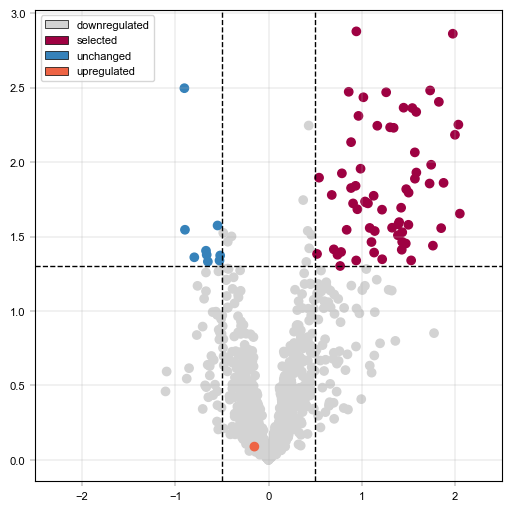

In [116]:
from alphatools.pl import Plots, add_lines
from alphatools.pl.plots import add_legend

### Basic colors, palettes and color maps for AlphaTools### Basic colors, palettes and color maps for AlphaTools

# Even in a notebook, we observe good practices and specify our variables once and upfront:
QUAN_COL = "delta_treatment_over_control"
SIGN_COL = "pvalue_treatment_over_control"
ID_COL = "Genes"
FC_CUTOFFS = [-0.5, 0.5]
HIGHLIGHTED_GENES = ["PAPPA"]
HIGHLIGHTED_NAME = "selected"
SIGN_CUTOFF = 0.05

# Create a simple figure
fig, axm = create_figure(nrows=1, ncols=1, figsize=(5, 5))

# For this, it is convenient to pull out the data into a single plotting dataframe
plotting_df = ttest_results[[QUAN_COL, SIGN_COL, ID_COL]].copy()

# We annotate significant hits with a color of our choice
plotting_df["status"] = "unchanged"
plotting_df.loc[(plotting_df[QUAN_COL] > FC_CUTOFFS[1]) & (plotting_df[SIGN_COL] < SIGN_CUTOFF), "status"] = (
    "upregulated"
)
plotting_df.loc[(plotting_df[QUAN_COL] < FC_CUTOFFS[0]) & (plotting_df[SIGN_COL] < SIGN_CUTOFF), "status"] = (
    "downregulated"
)
plotting_df.loc[(plotting_df[ID_COL].isin(HIGHLIGHTED_GENES)), "status"] = HIGHLIGHTED_NAME

# Some colors
color_dict = {
    "unchanged": colors.BaseColors.get("grey"),
    "upregulated": colors.BaseColors.get("red"),
    "downregulated": colors.BaseColors.get("blue"),
    HIGHLIGHTED_NAME: colors.BaseColors.get("orange"),
}

# Transform the pvalues to be -log10
plotting_df[f"-log10({SIGN_COL})"] = -nanlog(plotting_df[SIGN_COL], log=10)

# There is only one axis, next() returns it
ax = axm.next()

# Let's add a scatterplot
Plots.scatter(
    ax=ax,
    data=plotting_df,
    x_column=QUAN_COL,
    y_column=f"-log10({SIGN_COL})",
    color_column="status",
    color_dict=color_dict,
)

# We need lines for the limits
add_lines(ax, intercepts=FC_CUTOFFS, linestyle="--", color="black", linetype="vline")
add_lines(ax, intercepts=-np.log10(SIGN_CUTOFF), linestyle="--", color="black", linetype="hline")

# We want to label the top 10 points: AlphaTools labelling allows us to
# Anchor the labels neatly to either side, avoiding plot-clutter.
labelling_df = plotting_df.nlargest(10, f"-log10({SIGN_COL})").copy()
labelling_df = pd.concat(
    [
        labelling_df,
        plotting_df.loc[plotting_df["status"] == "selected", :],
    ]
)


# We want a legend that tells us what the colors mean
add_legend(
    ax=ax,
    levels=list(color_dict.keys()),
    palette=list(color_dict.values()),
)

# Lastly, we add labels to the axes

# Set some limits
ax.set_xlim(-2.5, 2.5)

# And save the figure, which should appear exactly like this as a .svg
# with editable fonts to be modified in Illustrator and used for publication.

In [85]:
plotting_df.loc[plotting_df.index.isin(HIGHLIGHTED_GENES), :]

,delta_treatment_over_control,pvalue_treatment_over_control,Genes,status,-log10(pvalue_treatment_over_control)


In [86]:
HIGHLIGHTED_GENES

['PAPPA']